In [1]:

# import the necessary packages
from keras.preprocessing import image as image_utils
from imagenet_utils import decode_predictions
from imagenet_utils import preprocess_input
from vgg16 import VGG16
import numpy as np
import argparse
from scipy.misc import imread
from matplotlib.pyplot import imshow
%matplotlib inline
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python3.4/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [15]:
image = imread('data/paintings_validation/painting_48155.JPEG')
img = load_img('data/paintings_validation/painting_48155.JPEG')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) 


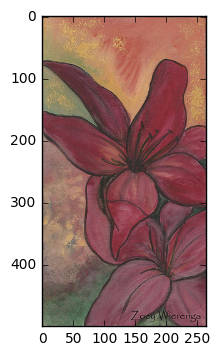

In [20]:
imshow(image)

## Image Augmentation Example

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/paintings_validation/painting_48155.JPEG')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/preview', save_prefix='painting', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

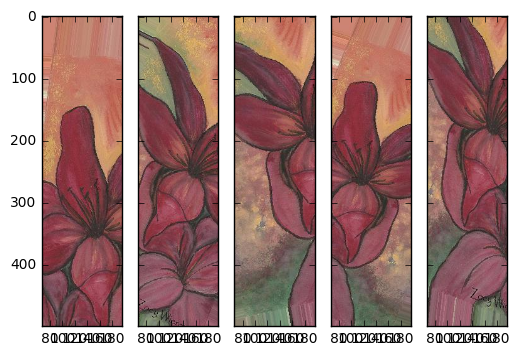

In [4]:
import glob

cat_images = [path for path in glob.glob('data/preview/*.jpeg')]

_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, sharey=True)
axes = [ax1, ax2, ax3, ax4, ax5]

for ax, cat in zip(axes, cat_images[:5]):
    ax.imshow(imread(cat))


## Start with 2K images to get 75% accuracy

In [5]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 150, 150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [30]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [31]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)



In [32]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2000,
        nb_epoch=50,
        validation_data=validation_generator,
        nb_val_samples=800)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/50
2000/2000 [==============================] - 22s - loss: 0.7312 - acc: 0.5650 - val_loss: 0.6178 - val_acc: 0.6763
Epoch 2/50
2000/2000 [==============================] - 20s - loss: 0.6419 - acc: 0.6590 - val_loss: 0.6154 - val_acc: 0.6658
Epoch 3/50
2000/2000 [==============================] - 20s - loss: 0.6102 - acc: 0.6725 - val_loss: 0.6101 - val_acc: 0.6881
Epoch 4/50
2000/2000 [==============================] - 20s - loss: 0.5879 - acc: 0.7150 - val_loss: 0.5684 - val_acc: 0.7166
Epoch 5/50
2000/2000 [==============================] - 21s - loss: 0.5749 - acc: 0.7020 - val_loss: 0.5799 - val_acc: 0.6955
Epoch 6/50
2000/2000 [==============================] - 21s - loss: 0.5619 - acc: 0.7075 - val_loss: 0.5726 - val_acc: 0.7050
Epoch 7/50
2000/2000 [==============================] - 20s - loss: 0.5561 - acc: 0.7295 - val_loss: 0.5499 - val_acc: 0.7400
Epoch 8/50
2000/2000 [==============================] - 20s - loss: 0.5449 - acc: 0.7410 - val_loss: 0.6120 - val_acc:

## Load VGG 16 MODEL

In [25]:
import os
import h5py

from keras.utils.data_utils import get_file
from keras.layers import Flatten, Dense, Input
from keras.applications import vgg16

TH_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
weights_path = get_file('vgg16_weights_th_dim_ordering_th_kernels_notop.h5',
                        TH_WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models')


In [17]:
from keras.models import Model
include_top = False
input_shape = (3, None, None)
img_input = Input(shape=input_shape)

# Block 1
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

if include_top:
    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='softmax', name='predictions')(x)


model = Model(img_input, x)
model.load_weights(weights_path)


In [26]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_data.shape

(2000, 512, 4, 4)

In [18]:
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(generator, 21010)
# save the output as a Numpy array
np.save(open('bottleneck_features_train_10k.npy', 'wb'), bottleneck_features_train)

generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, 8000)
np.save(open('bottleneck_features_validation_10k.npy', 'wb'), bottleneck_features_validation)

Found 21010 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


## Train FC layer to get 84% accuracy

In [19]:
train_data = np.load(open('bottleneck_features_train_10k.npy', 'rb'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 10408 + [1] * 10602)

validation_data = np.load(open('bottleneck_features_validation_10k.npy', 'rb'))
validation_labels = np.array([0] * 4000 + [1] * 4000)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels,
          nb_epoch=50, batch_size=32,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model_10k.h5')

Train on 21010 samples, validate on 8000 samples
Epoch 1/50
21010/21010 [==============================] - 4s - loss: 0.4974 - acc: 0.7849 - val_loss: 0.4627 - val_acc: 0.7979
Epoch 2/50
21010/21010 [==============================] - 3s - loss: 0.4146 - acc: 0.8235 - val_loss: 0.4378 - val_acc: 0.8141
Epoch 3/50
21010/21010 [==============================] - 7s - loss: 0.3913 - acc: 0.8375 - val_loss: 0.3803 - val_acc: 0.8397
Epoch 4/50
21010/21010 [==============================] - 14s - loss: 0.3760 - acc: 0.8466 - val_loss: 0.3951 - val_acc: 0.8369
Epoch 5/50
21010/21010 [==============================] - 14s - loss: 0.3683 - acc: 0.8547 - val_loss: 0.3882 - val_acc: 0.8415
Epoch 6/50
21010/21010 [==============================] - 14s - loss: 0.3577 - acc: 0.8568 - val_loss: 0.3959 - val_acc: 0.8426
Epoch 7/50
21010/21010 [==============================] - 13s - loss: 0.3459 - acc: 0.8634 - val_loss: 0.4120 - val_acc: 0.8340
Epoch 8/50
21010/21010 [==============================] - 

## Fine-turn Conv layer to get 88% accuracy

In [26]:
# build the VGG16 network
img_width, img_height = 150, 150
top_model_weights_path = 'bottleneck_fc_model_10k.h5'

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# model = Model(img_input, x)
model.load_weights(weights_path)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model.add(top_model)

In [27]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [28]:
# prepare data augmentation configuration
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 21010
nb_validation_samples = 8000
nb_epoch = 50

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')

# fine-tune the model
model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Found 21010 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Epoch 1/50
21010/21010 [==============================] - 372s - loss: 0.4285 - acc: 0.8179 - val_loss: 0.4490 - val_acc: 0.8323
Epoch 2/50
21010/21010 [==============================] - 372s - loss: 0.3495 - acc: 0.8568 - val_loss: 0.3799 - val_acc: 0.8400
Epoch 3/50
21010/21010 [==============================] - 371s - loss: 0.3353 - acc: 0.8602 - val_loss: 0.3707 - val_acc: 0.8374
Epoch 4/50
21010/21010 [==============================] - 373s - loss: 0.3123 - acc: 0.8713 - val_loss: 0.3702 - val_acc: 0.8646
Epoch 5/50
21010/21010 [==============================] - 373s - loss: 0.2914 - acc: 0.8791 - val_loss: 0.3790 - val_acc: 0.8651
Epoch 6/50
21010/21010 [==============================] - 373s - loss: 0.2833 - acc: 0.8847 - val_loss: 0.3683 - val_acc: 0.8668
Epoch 7/50
21010/21010 [==============================] - 372s - loss: 0.2701 - acc: 0.8914 - val_loss: 0.3904 - val_acc: 0.8542
Epoch 8/50
2

In [ ]:
# model.save('fineturn_conv_50epoch_model.h5')
model.save_weights('finetune_weights_10k.h5')